In [74]:
import pandas as pd
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Batter Segmentation Analysis

In [75]:
batter_data = pd.read_csv('C:/Users/wanns/OneDrive/Desktop/Coding/MSDS/DS6021-Project/data/cleaned/final_batters_df.csv')

In [76]:
batter_data.head()

,row_id,playerID,year,position,age,avg_salary_year,free_agent_salary,contract_length,AB,R,...,E,DP,PB,WP,ZR,won_cy_young,won_mvp,won_gold_glove,won_silver_slugger,all_star
0,baergca01_2003,baergca01,2003,2B,35,2.573473e+06,1000000.0,1.0,389,48,...,4.0,27.0,0.0,0.0,NaN,0,0,0,0,0
1,barajro01_2003,barajro01,2003,C,28,2.573473e+06,500000.0,1.0,480,40,...,2.0,10.0,12.0,0.0,NaN,0,0,0,0,0
2,belliro01_2003,belliro01,2003,2B,28,2.573473e+06,1100000.0,1.0,1100,172,...,30.0,177.0,0.0,0.0,NaN,0,0,0,0,0
3,blanche01_2003,blanche01,2003,C,32,2.573473e+06,750000.0,1.0,686,61,...,10.0,14.0,13.0,0.0,NaN,0,0,0,0,0
4,butlebr02_2003,butlebr02,2003,2B,25,2.573473e+06,NaN,1.0,553,85,...,17.0,81.0,0.0,0.0,NaN,0,0,0,0,0


In [77]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

In [78]:
# decide what features to use for clustering (initially remove categorical features where distance metrics don't make sense)
X = batter_data.select_dtypes(include=['float64', 'int64'])
X.dtypes

year                    int64
age                     int64
avg_salary_year       float64
free_agent_salary     float64
contract_length       float64
AB                      int64
R                       int64
H                       int64
2B                      int64
3B                      int64
HR                      int64
RBI                     int64
SB                      int64
CS                      int64
BB                      int64
SO                      int64
IBB                     int64
HBP                     int64
SH                      int64
SF                      int64
GIDP                    int64
InnOuts               float64
PO                    float64
A                     float64
E                     float64
DP                    float64
PB                    float64
WP                    float64
ZR                    float64
won_cy_young            int64
won_mvp                 int64
won_gold_glove          int64
won_silver_slugger      int64
all_star  

In [79]:
# remove variables where distance isn't meaningful like year and agent salary since we want to look at performance for batters (offense stats only), keep stats we want to compare across groups
X = X.drop(columns=['year', 'free_agent_salary', 'PB', 'WP', 'won_cy_young', 'won_mvp', 'won_gold_glove', 'won_silver_slugger', 'all_star', 'PO', 'InnOuts', 'A', 'E', 'ZR'])
X.columns


Index(['age', 'avg_salary_year', 'contract_length', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP',
       'DP'],
      dtype='object')

In [80]:
# 1. Total Plate Appearances (The denominator for rates)
X['PA'] = X['AB'] + X['BB'] + X['HBP'] + X['SF'] + X['SH']

# 2. Slugging Percentage (SLG)
X['SLG'] = ((X['H'] - X['2B'] - X['3B'] - X['HR']) + 
            (2 * X['2B']) + (3 * X['3B']) + (4 * X['HR'])) / X['AB']

# 3. Plate Discipline Metrics 
X['BB_rate'] = X['BB'] / X['PA']   # Walk rate: Measures patience
X['SO_rate'] = X['SO'] / X['PA']   # Strikeout rate: Measures contact ability

# 4. Luck/Fielding Metric (BABIP)
# Measures hit rate on balls in play (excludes HR and SO)
X['BABIP'] = (X['H'] - X['HR']) / (X['AB'] - X['SO'] - X['HR'] + X['SF'])

# 5. Baserunning Efficiency
# Success rate of stealing bases (handling divide by zero if no attempts)
X['SB_EFF'] = X['SB'] / (X['SB'] + X['CS'])
X['SB_EFF'] = X['SB_EFF'].fillna(0) # Fill players with 0 steal attempts

# 6. Drop original count columns
X.drop(columns=['AB', 'PA', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS',
                'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'DP'], inplace=True)
X.columns


Index(['age', 'avg_salary_year', 'contract_length', 'SLG', 'BB_rate',
       'SO_rate', 'BABIP', 'SB_EFF'],
      dtype='object')

We dropped raw counting stats that are heavily affected by playing time, aka PA, and replaced them with rate-based metrics based on plate appearances, so we are comparing stats based on assumption that they have the same number of opportunities to make a play. The 7 variables we have now are:

age - player age, same as before

avg_salary_year - average annual salary of player, same as before

contract_length - length of contract in years, same as before

SLG - slugging percentage power/hitting metric, new metric

BB_rate - walk rate discipline metric, new metric

SO_rate - strikeout rate discipline metric, new metric

BABIP - batting average on balls in play fielding metric, new metric

SB_EFF - stolen base efficiency baserunning metric, new metric

### Missing Values

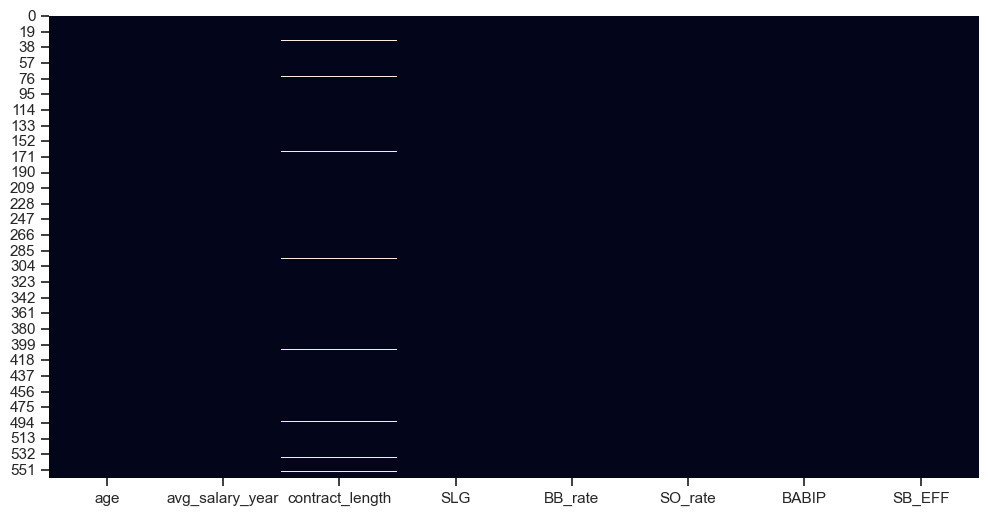

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(X.isnull(), cbar=False)
plt.show()

The y-axis is the physical rows in our data, and the white bars are missing data, we see that missing data is very sparse and looks to only be a very small percentage of contract_length missing, but let's check to see if this is missing at random or not to see what method to use to handle this.

In [82]:
from scipy.stats import ttest_ind

# 1. Create the missingness indicator
X['contract_length_missing'] = X['contract_length'].isnull().astype(int)

features_to_test = ['age', 'avg_salary_year', 'SLG', 'BB_rate','SO_rate', 'BABIP', 'SB_EFF'] 

for feature in features_to_test:
    temp_df = X.copy()
    
    # Separate the feature values into two groups
    group_missing = temp_df.loc[temp_df['contract_length_missing'] == 1, feature]
    group_observed = temp_df.loc[temp_df['contract_length_missing'] == 0, feature]
    
    # t-test
    t_stat, p_value = ttest_ind(group_missing, group_observed, equal_var=False)

    print(f"\nFeature: **{feature}**")
    print(f"Mean (Missing contract_length): {group_missing.mean():.4f}")
    print(f"Mean (Observed contract_length): {group_observed.mean():.4f}")
    print(f"P-value: {p_value:.6f}")


Feature: **age**
Mean (Missing contract_length): 32.3333
Mean (Observed contract_length): 32.6193
P-value: 0.715489

Feature: **avg_salary_year**
Mean (Missing contract_length): 3347757.0963
Mean (Observed contract_length): 3177367.3206
P-value: 0.423801

Feature: **SLG**
Mean (Missing contract_length): 0.3800
Mean (Observed contract_length): 0.4106
P-value: 0.141113

Feature: **BB_rate**
Mean (Missing contract_length): 0.0800
Mean (Observed contract_length): 0.0830
P-value: 0.659986

Feature: **SO_rate**
Mean (Missing contract_length): 0.1948
Mean (Observed contract_length): 0.1735
P-value: 0.374190

Feature: **BABIP**
Mean (Missing contract_length): 0.2897
Mean (Observed contract_length): 0.2929
P-value: 0.690901

Feature: **SB_EFF**
Mean (Missing contract_length): 0.6182
Mean (Observed contract_length): 0.6045
P-value: 0.834106


No significant differences between the two groups, so it does seem to be missing at random.

In [83]:
Xorig = X.copy()
X = X.drop(columns=['avg_salary_year', 'contract_length', 'contract_length_missing'])

In [84]:
K_values = list(range(1, 11))
wcss = []

for k in K_values:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)
    inertia = pipe["kmeans"].inertia_
    wcss.append(inertia)


fig = px.line(
    x=K_values,
    y=wcss,
    markers=True,
    labels={"x": "Number of Clusters (K)", "y": "WCSS"}
)

fig.update_layout(height=500, width=700)
fig.show()

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

We see a sort of flatting point around k = 3 or 4 to form the "elbow", so k = 3 or 4 seems to be the optimal number of clusters to use, but since the elbow graph is a bit subjective, let's look at the silhouette score to determine what it says about the optimal k.

In [85]:
sil_scores = []
K_values_sil = list(range(2, 11))

for k in K_values_sil:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)

    labels = pipe["kmeans"].labels_

    sil = silhouette_score(X, labels)

    sil_scores.append(sil)


fig = px.line(
    x=K_values_sil,
    y=sil_scores,
    markers=True,
    title="Silhouette Scores (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "Silhouette Score"}
)

fig.update_layout(height=500, width=700)
fig.show()


c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

Based on the silhouette graph, we can see that 2 clusters has the best group definition compared to any other k by a clear margin. Therefore we will proceed with our analysis using k = 2.

### Cumlative Variance Explained by PCA

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



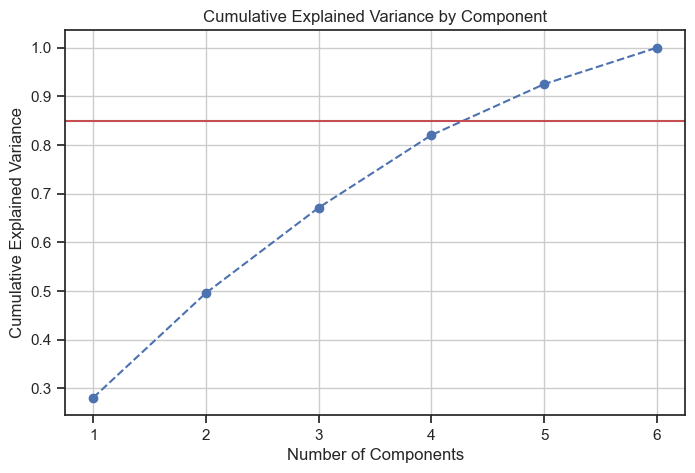

In [86]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

# 2. Fit PCA with all possible components (6)
pipe.fit(X)
pca = pipe["pca"]

# 3. Plot the Cumulative Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 7), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='-') # Threshold line at 90%
plt.grid()
plt.show()

In [87]:
eigenvalues = pipe["pca"].explained_variance_
variance_ratios = pipe["pca"].explained_variance_ratio_
cumulative_variance = variance_ratios.cumsum()

import pandas as pd

pd.DataFrame({
    'Eigenvalue': eigenvalues,
    'Variance Proportion': variance_ratios,
    'Cumulative Variance': cumulative_variance
}, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

,Eigenvalue,Variance Proportion,Cumulative Variance
PC1,1.686250,0.280541,0.280541
PC2,1.293520,0.215202,0.495743
PC3,1.054114,0.175373,0.671116
PC4,0.897141,0.149257,0.820373
PC5,0.629345,0.104704,0.925076
PC6,0.450344,0.074924,1.000000


It looks like 5 PCA components is sufficient and captures around 92% of the variance, so we have successfully reduced 6 dimensions down to 5, using 4 dimensions is a bit too much of a loss in terms of variance explained considering a threshold of 85% variance explained.

### Principal Direction Contributions

In [88]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

# 2. Fit PCA with 5 components
pipe.fit(X)
pca = pipe["pca"]

pca_loadings = pd.DataFrame(
    pipe["pca"].components_.T, 
    index=X.columns,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)
pca_loadings


c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



,PC1,PC2,PC3,PC4,PC5
age,0.089496,-0.323033,0.787242,0.393956,0.236682
SLG,0.594044,-0.193300,-0.003956,-0.281751,-0.519570
BB_rate,0.565635,0.276235,0.109400,0.401259,-0.264452
SO_rate,0.376814,0.607209,-0.103421,0.040493,0.568661
BABIP,0.412383,-0.503421,-0.100163,-0.402729,0.523480
SB_EFF,0.084322,-0.399804,-0.589524,0.663759,0.081770


We see here what each of the 5 principal components breaks down into. For example, PC1 can be decomposed into relatively high positive loadings for SLG and BB_rate, as well as BABIP and SO_rate, while age, SB_EFF do not really contribute to this dimensino. This means the more positive an observations value in PC1, the higher it is correlated with higher slugging percentage and higher walking rates.

### Principal Component Scores

In [89]:
X_pca = pipe[:-1].transform(X) # Exclude the KMeans step to get PCA-transformed data
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=X.index)
X_pca

,PC1,PC2,PC3,PC4,PC5
0,-0.038820,-2.586519,-0.183556,-0.145448,0.438512
1,-2.178507,0.869381,-1.905948,1.261836,-0.179540
2,-0.538664,0.234908,-1.148627,-0.228378,-0.516800
3,-1.637964,1.653400,0.287118,0.880722,-0.311524
4,-2.448262,0.671338,-1.121933,-1.510969,-1.351787
...,...,...,...,...,...
556,0.391613,-0.596625,0.361150,0.593798,-0.574152
557,0.399495,0.082463,-0.801156,-1.087778,-0.025436
558,2.914023,1.440352,-1.031218,-0.613561,-0.139612
559,1.942963,0.597462,-1.631940,-0.361951,0.336143


Here we see the data being converted into our new input space, we have the reduction to 5 dimensions being displayed here, each observation in our data is now represented by the 5 PCs.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



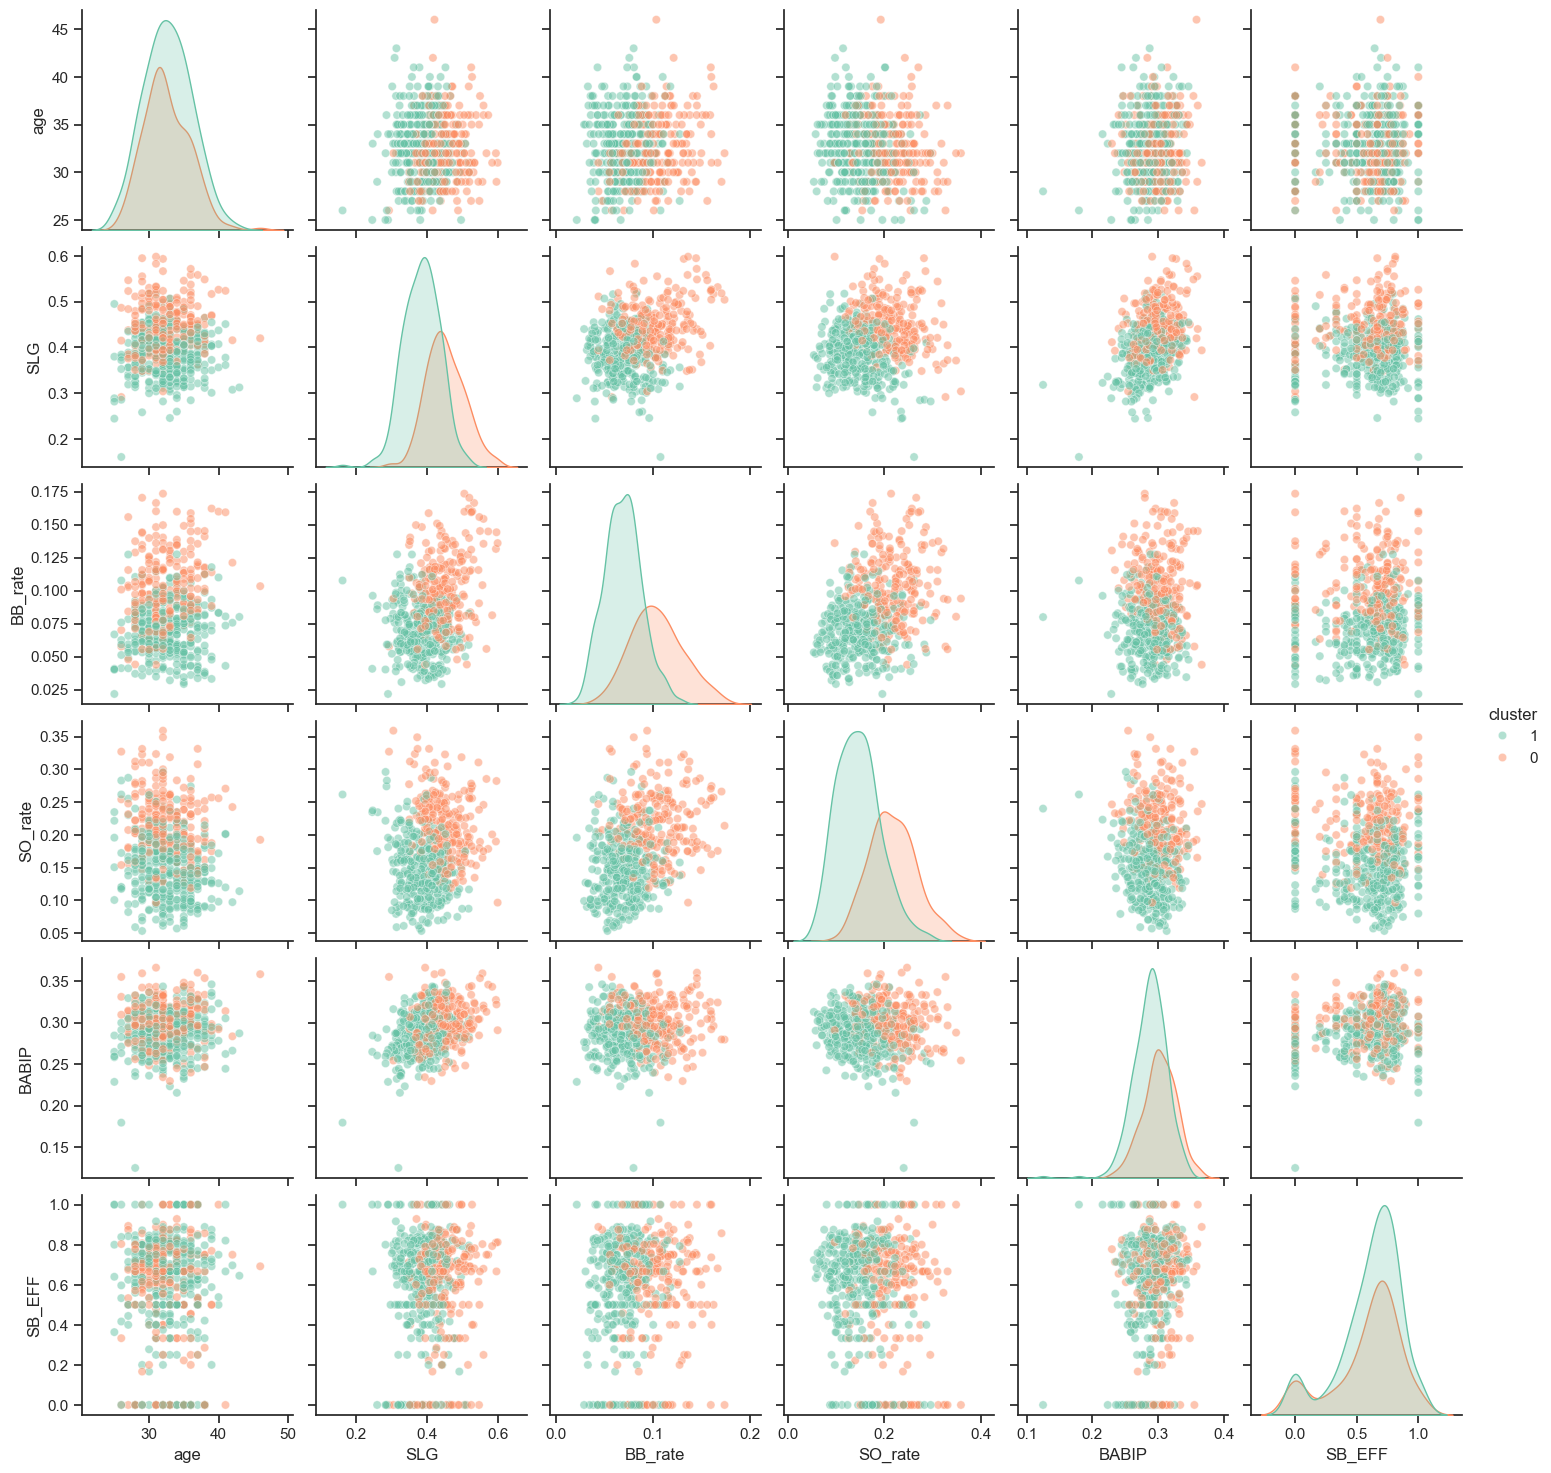

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd

# original data kmeans clustering analysis

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X)
labels = pipe["kmeans"].labels_

X_plot = pd.DataFrame(X, columns=['age', 'SLG', 'BB_rate', 'SO_rate', 'BABIP', 'SB_EFF'])
X_plot['cluster'] = labels.astype(str)

# pairwise plot of PC Scores
sns.set(style="ticks")
pair_plot = sns.pairplot(
    X_plot, 
    hue='cluster', 
    palette='Set2', 
    diag_kind='kde',
    plot_kws={'alpha': 0.5})

plt.show()

From the pairwise plot of all combinations of the original variables, we can see a pattern that strengthens our PCA findings earlier, BABIP, SO_rate, BB_rate, and SLG seemed to have the best separation of the two clusters (recall these are the 4 main loading factors in PC1 that explains almost 30% of the variance by itself), so PC1 not only explains a lot of variance but also contributes a lot to separation.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



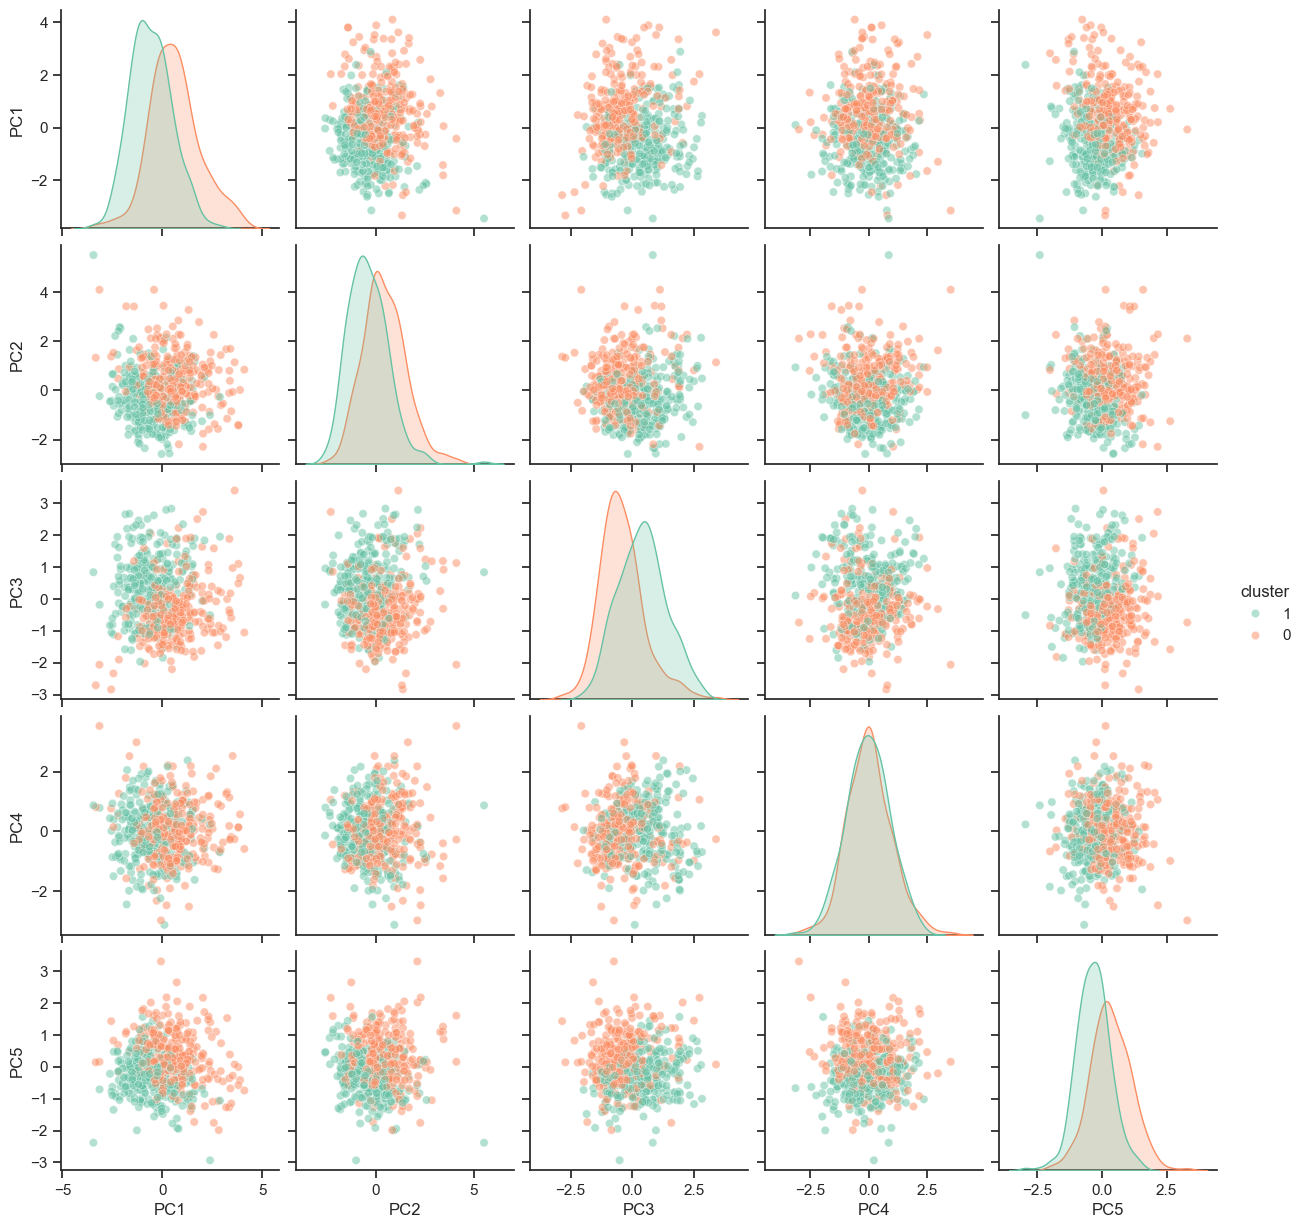

In [91]:
# pca transformed data kmeans clustering analysis

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X_pca)
labels = pipe["kmeans"].labels_

X_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_plot['cluster'] = labels.astype(str)
cluster_labels = X_plot['cluster'].unique()

def plot_pca_biplot(X_pca_scores, loadings_matrix, labels, pc_x=1, pc_y=2, scale_factor=8, cluster_distinction=True):
    """
    Generates a PCA Biplot for any two Principal Components (PCX vs PCY), 
    colored by K-means cluster labels.

    Args:
        X_pca_scores (pd.DataFrame or np.array): The PCA transformed data (PC scores).
        loadings_matrix (pd.DataFrame): The matrix of PCA loadings.
        labels (np.array): The K-means cluster labels for each data point.
        pc_x (int): The index of the PC for the X-axis (e.g., 1 for PC1).
        pc_y (int): The index of the PC for the Y-axis (e.g., 2 for PC2).
        scale_factor (float): Multiplier to scale the loading vectors for visualization.
    """
    
    pc_x_col = f'PC{pc_x}'
    pc_y_col = f'PC{pc_y}'
    
    if pc_x_col not in X_plot.columns or pc_y_col not in X_plot.columns:
        raise ValueError(f"PC index {pc_x} or {pc_y} is out of range. Max PC is {len(X_plot.columns)-1}.")
        
    cluster_labels = X_plot['cluster'].unique()

    fig = go.Figure()

    # Scatter Plot of Data Points (Scores)
    if cluster_distinction:
        for label in cluster_labels:
            df_cluster = X_plot[X_plot['cluster'] == label]
            fig.add_trace(go.Scatter(
                x=df_cluster[pc_x_col], 
                y=df_cluster[pc_y_col], 
                mode='markers',
                marker=dict(size=8, opacity=0.7),
                name=f'Cluster {label}'
            ))
    else:
        fig.add_trace(go.Scatter(
            x=X_plot[pc_x_col], 
            y=X_plot[pc_y_col], 
            mode='markers',
            marker=dict(size=8, opacity=0.7),
        ))

    # 3. Add Loadings (Arrows)
    # The loadings matrix contains the coordinates for the arrows
    loading_df = loadings_matrix[[pc_x_col, pc_y_col]].copy()
    loading_df['var'] = loading_df.index

    for i, row in loading_df.iterrows():
        fig.add_trace(go.Scatter(
            x=[0, row[pc_x_col] * scale_factor], 
            y=[0, row[pc_y_col] * scale_factor],
            mode='lines+markers+text',
            text=[None, row["var"]],
            textposition='top center',
            line=dict(color='red', width=2),
            marker=dict(size=5, color='red'),
            showlegend=False,
            textfont=dict(color='red', size=12)
        ))

    # 4. Final Layout
    fig.update_layout(
        title=f'PCA Biplot: {pc_x_col} vs {pc_y_col}',
        xaxis_title=pc_x_col,
        yaxis_title=pc_y_col,
        height=600,
        width=800,
        # Ensure the arrow origin (0,0) is visible
        xaxis=dict(zeroline=True, zerolinewidth=2, zerolinecolor='lightgrey'),
        yaxis=dict(zeroline=True, zerolinewidth=2, zerolinecolor='lightgrey'),
    )
    fig.show()

plot_pca_biplot(X_pca, pca_loadings, labels, pc_x=1, pc_y=2)

plot_pca_biplot(X_pca, pca_loadings, labels, pc_x=1, pc_y=3)

plot_pca_biplot(X_pca, pca_loadings, labels, pc_x=2, pc_y=3)

# pairwise plot of PC Scores
sns.set(style="ticks")
pair_plot = sns.pairplot(
X_plot, 
hue='cluster', 
palette='Set2', 
diag_kind='kde',
plot_kws={'alpha': 0.5})

plt.show()

Most of the PCs do ok at separating clusters, P4 doesn't do that well, so although it explains a lot of general variance in the data, it doesn't help much to minimize within cluster variance.

### Investigate characteristics of each group

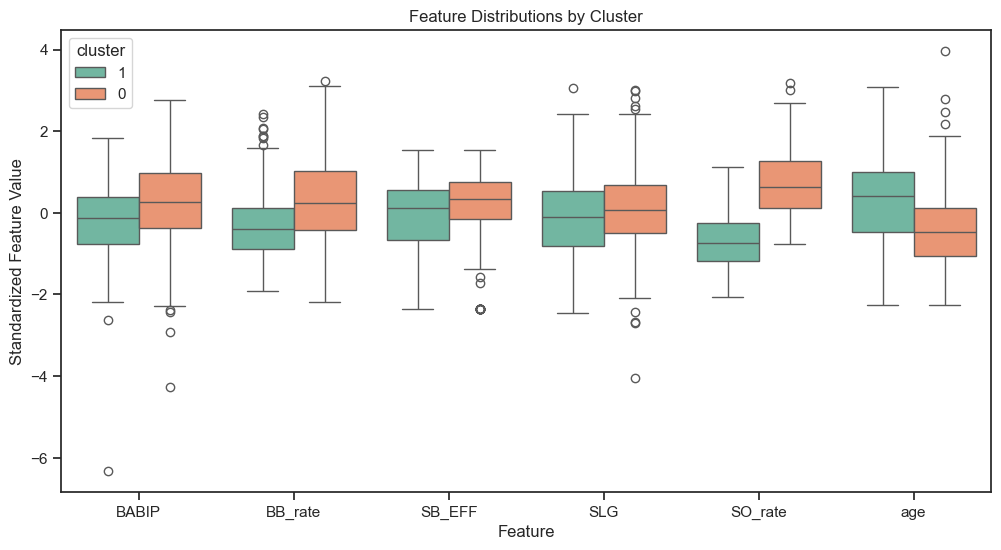

In [92]:
X['cluster'] = labels.astype(str)
# standardize to account for range differences
X_scaled = X.copy()
X_scaled['cluster'] = labels.astype(str)
feature_cols = X.columns.difference(['cluster'])
X_scaled[feature_cols] = StandardScaler().fit_transform(X[feature_cols])
plot_df = X_scaled.melt(id_vars='cluster', value_vars=X_scaled.columns.difference(['cluster']), var_name='Feature', value_name='Value')
plt.figure(figsize=(12,6))
sns.boxplot(x='Feature', y='Value', hue='cluster', data=plot_df, palette='Set2')
plt.title("Feature Distributions by Cluster")
plt.ylabel("Standardized Feature Value")
plt.xlabel("Feature")
plt.show()

We see the main differences between the two clusters is that cluster 1 has players mostly below the average age while cluster 0 has players mostly above the average age. Cluster 0 also has players with below average strikeout rates while cluster 1 has players with higher strike out rates. Other features have distinctions between clusters but not as clear. This supports an idea that cluster 1 has younger players who play more aggressive and play power plays rather than safely, while cluster 0 has older players who have adjusted to the pitchers in the MLB and play less aggressively.

### Salary and Contract Length Comparisons Across Clusters

In [93]:
Xorig['cluster'] = labels.astype(str)
Xorig.groupby('cluster')[['avg_salary_year', 'contract_length']].agg(['mean','median','std', 'count'])

avg_salary_year                                    contract_length  \
                   mean        median            std count            mean   
cluster                                                                      
0          3.325404e+06  3.278747e+06  549647.401740   274        1.705660   
1          3.043161e+06  2.941436e+06  454622.532876   287        1.580986   

                                
        median       std count  
cluster                         
0          1.0  1.483548   265  
1          1.0  1.184615   284

In [94]:
fig_salary = px.box(
    Xorig, 
    x='cluster', 
    y='avg_salary_year', 
    color='cluster',
    title="Average Yearly Salary by Batter Cluster",
    labels={'avg_salary_year': 'Avg Salary per Year ($)', 'cluster': 'Batter Segment'},
)
fig_salary.show()

fig_len = px.box(
    Xorig, 
    x='cluster', 
    y='contract_length', 
    color='cluster',
    title="Contract Length by Batter Cluster",
    labels={'contract_length': 'Years of Contract', 'cluster': 'Batter Segment'},
)
fig_len.show()

Cluster 1 appears to get payed higher salaries more often, and both have relatively similar contract lengths, probably since most teams like to sign for a year or two unless the player has so much potential they think they will last longer.

### Is this significant difference?

In [95]:
from scipy import stats

cluster_0_salary = Xorig[Xorig['cluster'] == '0']['avg_salary_year']
cluster_1_salary = Xorig[Xorig['cluster'] == '1']['avg_salary_year']

t_stat, p_val = stats.ttest_ind(cluster_0_salary, cluster_1_salary, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Significant. The market values these player segments differently.")
else:
    print("Result: Not significant. The clusters do not represent a meaningful pay difference.")

cluster_0_contract = Xorig[Xorig['cluster'] == '0']['contract_length'].dropna()
cluster_1_contract = Xorig[Xorig['cluster'] == '1']['contract_length'].dropna()

t_stat, p_val = stats.ttest_ind(cluster_0_contract, cluster_1_contract, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Significant. The market contracts these player segments differently.")
else:
    print("Result: Not significant. The clusters do not represent a meaningful contract length difference.")

T-statistic: 6.6109
P-value: 9.3325e-11
Result: Significant. The market values these player segments differently.
T-statistic: 1.0832
P-value: 2.7922e-01
Result: Not significant. The clusters do not represent a meaningful contract length difference.


In [96]:
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

d = cohens_d(cluster_0_contract, cluster_1_contract)
print(f"contract Cohen's d: {d:.4f}")
d = cohens_d(cluster_0_salary, cluster_1_salary)
print(f"salary Cohen's d: {d:.4f}")

contract Cohen's d: 0.0932
salary Cohen's d: 0.5608


Negligable gap in contract length, but the salary gap for cluster 1 is a sizeable effect, being on average half a standard deviation higher from cluster 0.